## Creando os diagramas Txy, Pxy, e xy diagrams para unha mestura binaria (auga-etanol) con UNIFAC modificado (Dortmund) ¶

In [2]:
!pip install thermo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 95.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 96.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 99.8 MB/s eta 0:00:00


# Thermo

In [3]:
# Seleccionar as condicións e os imports
from scipy.constants import bar
from thermo import Chemical

In [5]:
fluido = Chemical('811-97-2')
fluido.ID

'811-97-2'

In [10]:
CO2 = Chemical('CO2')
CO2.ID
CO2.CAS
CO2.Tb
CO2.Tm

216.65

In [21]:
print(f'A presión Crítica do {CO2.CAS} é de\n {CO2.Pc/101325:.0f} bar')

A presión Crítica do 124-38-9 é de
 73 bar


In [ ]:
from thermo import ChemicalConstantsPackage, PRMIX, CEOSLiquid, CEOSGas, FlashPureVLS

In [ ]:
# constants, correlations = ChemicalConstantsPackage([fluido.ID])

In [ ]:
# Establecer condicións e imports
from scipy.constants import bar
from thermo import *
from thermo.unifac import DOUFSG, DOUFIP2016

fluido = '811-97-2' # 'dichlorodifluoromethane'
constants, correlations = ChemicalConstantsPackage.from_IDs([fluido])

zs = [1]

eos_kwargs = dict(Tcs=constants.Tcs, Pcs=constants.Pcs, omegas=constants.omegas)
liquid = CEOSLiquid(PRMIX, HeatCapacityGases=correlations.HeatCapacityGases,
                    eos_kwargs=eos_kwargs)
gas = CEOSGas(PRMIX, HeatCapacityGases=correlations.HeatCapacityGases,
              eos_kwargs=eos_kwargs)
flasher = FlashPureVLS(constants, correlations, liquids=[liquid], gas=gas, solids=[])

T1 = 273.15+40
state_1 = flasher.flash(VF=0, T=T1)
saturation_state_1 = flasher.flash(T=-20+273.15, VF=1)
# A redacción non está clara para o estado 2, pero termodinámicamente a súa é o que ten sentido
state_2 = flasher.flash(H=state_1.H(), P=saturation_state_1.P)
# Comproba que o flash baixa a presión
assert state_2.P < state_1.P
state_3 = flasher.flash(P=state_2.P, VF=1)
saturation_state_2 = flasher.flash(T=30+273.15, VF=1)
state_4 = flasher.flash(P=saturation_state_2.P, S=state_3.S())
states = [state_1, state_2, state_3, state_4]

condensation_duty = (state_1.H() - state_4.H())
heating_duty = state_3.H() - state_2.H()
compressing_duty = state_4.H() - state_3.H()
condensation_duty, heating_duty, compressing_duty

(-17122.540093663116, 13364.214905214762, 3758.3251884483607)

In [ ]:
# Check the cycle convergence
cycle_error = sum([condensation_duty, heating_duty, compressing_duty])
cycle_error

In [22]:
for state in states:
    print(f'T={state.T:.2f} K, P={state.P:.2f} Pa, VF={state.VF:.2f}, S={state.S():.2f} J/(mol*K), H={state.H():.2f} J/(mol)')

NameError: ignored

In [24]:
from thermo import *
from thermo.unifac import DOUFSG, DOUFIP2016
# Load constants and properties
constants, properties = ChemicalConstantsPackage.from_IDs(['ethanol', 'water'])
# Objects are initialized at a particular condition
T = 300
P = 1e5
zs = [.5, .5]

# Use Peng-Robinson for the vapor phase
eos_kwargs = {'Pcs': constants.Pcs, 'Tcs': constants.Tcs, 'omegas': constants.omegas}
gas = CEOSGas(PRMIX, HeatCapacityGases=properties.HeatCapacityGases, eos_kwargs=eos_kwargs)

# Configure the activity model
GE = UNIFAC.from_subgroups(chemgroups=constants.UNIFAC_Dortmund_groups, version=1, T=T, xs=zs,
                           interaction_data=DOUFIP2016, subgroups=DOUFSG)
# Configure the liquid model with activity coefficients
liquid = GibbsExcessLiquid(
    VaporPressures=properties.VaporPressures,
    HeatCapacityGases=properties.HeatCapacityGases,
    VolumeLiquids=properties.VolumeLiquids,
    GibbsExcessModel=GE,
    equilibrium_basis='Psat', caloric_basis='Psat',
    T=T, P=P, zs=zs)

# Create a flasher instance, assuming only vapor-liquid behavior
flasher = FlashVL(constants, properties, liquid=liquid, gas=gas)

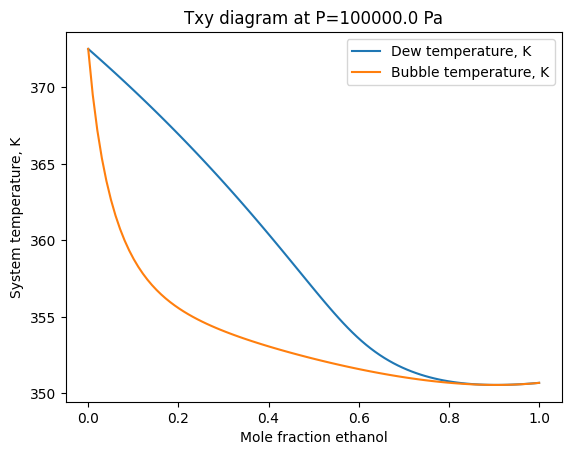

In [27]:
# Create a T-xy plot at 1 bar
_ = flasher.plot_Txy(P=1e5, pts=100)

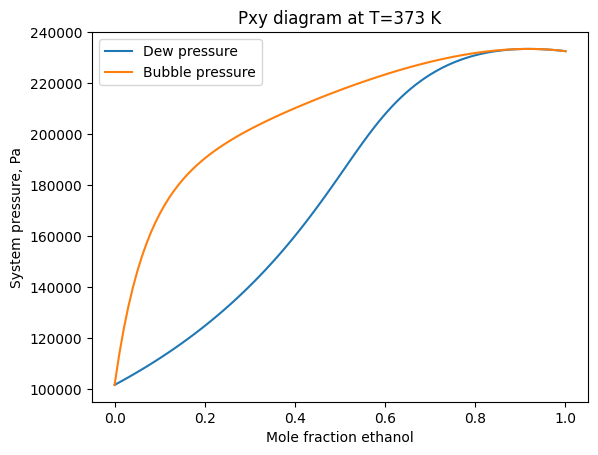

In [28]:
# Create a P-xy plot at 373 Kelvin
_ = flasher.plot_Pxy(T=373, pts=100)

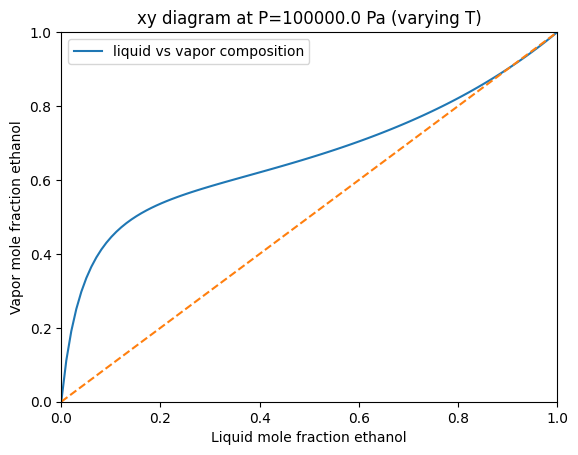

In [29]:
# Create a xy diagram at 1 bar
_ = flasher.plot_xy(P=1e5, pts=100)